# LangChain with Open Source LLM (Hosted on SageMaker) and Open Source Embeddings (Hosted in Colab)

In this notebook, we'll walk through the process of using a custom model with a SageMaker endpoint, as well as how to leverage local embeddings models to have a completely opensource RAG solution!

Let's start with our dependencies!

In [1]:
!pip install langchain -q -U

In [2]:
!pip install huggingface-hub -q -U

In [3]:
!pip install requests -U -q

We'll need our Hugging Face token to access our Inference Endpoint.

In [4]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HuggingFace Write Token: ")

### Sample Request

Let's submit a sample request to the SageMaker endpoint on Hugging Face!

+ Created Sagemaker endpoint with [mistralai/Mistral-7B-v0.1](https://huggingface.co/mistralai/Mistral-7B-v0.1)

In [5]:
import requests
import json
max_new_tokens = 256
top_p = 0.9
temperature = 0.1
model_api_gateway = "https://jt20dl7igt7c4gta.us-east-1.aws.endpoints.huggingface.cloud"### YOUR MODEL ENDPOINT HERE

prompt = "Hello! How are you?"

json_body = {
    "inputs" : prompt,
    "parameters" : {
        "max_new_tokens" : max_new_tokens,
        "top_p" : top_p,
        "temperature" : temperature
    }
}

headers = {
  "Authorization": f"Bearer {os.environ['HF_TOKEN']}",
  "Content-Type": "application/json"
}
response = requests.post(model_api_gateway, json=json_body, headers=headers)
print(json.dumps(response.json(),indent=4,ensure_ascii=False).encode('utf8').decode())

[
    {
        "generated_text": " I’m doing well, thank you. I’m still in the process of moving, but I’m getting there. I’m also still working on my new book, which is coming along nicely. I’m hoping to have it out by the end of the year.\n\nI’m also working on a new project that I’m really excited about. It’s a podcast called “The Creative Life.” It’s all about the creative process and how to live a creative life. I’m really excited about it and I hope you’ll check it out when it’s ready.\n\nI’m also working on a new book called “The Creative Life.” It’s all about the creative process and how to live a creative life. I’m really excited about it and I hope you’ll check it out when it’s ready.\n\nI’m also working on a new book called “The Creative Life.” It’s all about the creative process and how to live a creative life. I’m really excited about it and I hope you’ll check it out when it’s ready.\n\nI’m also working on a new book called “The Creative Life.” It’s"
    }
]


### Create LLM Class for SageMaker endpoint

We'll want to extend the LLM base class to create a Llama2SageMaker class that handles interacting with our endpoint.

Be sure to follow the pattern above for calling the endpoint!

In [6]:
import requests
from typing import Any, List, Mapping, Optional
from langchain.callbacks.manager import CallbackManagerForLLMRun
from langchain.llms.base import LLM
import re

class Llama2SageMaker(LLM):
    max_new_tokens: int = 256
    top_p: float = 0.9
    temperature: float = 0.1
    model_api_gateway: str

    @property
    def _llm_type(self) -> str:
        return "Llama2SageMaker"

    def _call(
        self,
        prompt: str,
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
    ) -> str:
        if stop is not None:
            raise ValueError("stop kwargs are not permitted.")

        json_body = {
           ### YOUR CODE HERE
            "inputs" : prompt,
         "parameters" : {
        "max_new_tokens" : self.max_new_tokens,
        "top_p" : self.top_p,
        "temperature" : self.temperature
    }
        }

        headers = {
             ### YOUR CODE HERE
            "Authorization": f"Bearer {os.environ['HF_TOKEN']}",
            "Content-Type": "application/json"
            
        }

        response = requests.post(model_api_gateway,json=json_body,headers=headers) ### YOUR CODE HERE

        try:
        #   print(response.json())
          final_response = str(response.json()[0]["generated_text"])
          final_response=re.sub(r'\n+','\n',final_response).strip()
          final_response=re.sub(r'\s+','')
          
          return final_response
        
        except Exception as e:
          return response.text

    @property
    def _identifying_params(self) -> Mapping[str, Any]:
        """Get the identifying parameters."""
        return {
            "max_new_tokens" : self.max_new_tokens,
            "top_p" : self.top_p,
            "temperature" : self.temperature
        }

In [7]:
llm = Llama2SageMaker(
    model_api_gateway="https://jt20dl7igt7c4gta.us-east-1.aws.endpoints.huggingface.cloud"
)

Let's go ahead and test this out!

In [8]:
llm("What is Retrieval Augmented Generation?")

'[{"generated_text":"\\n\\nRetrieval Augmented Generation (RAG) is a new approach to natural language generation (NLG) that combines the best of both worlds: the ability to generate new text on the fly, and the ability to retrieve existing text from a knowledge base.\\n\\nRAG is a powerful tool that can be used to create high-quality, personalized content at scale. It can be used to generate everything from product descriptions to news articles, and it can be customized to fit any brand or style.\\n\\nRAG is still in its early stages, but it has the potential to revolutionize the way we create content. If you’re looking for a way to create high-quality, personalized content at scale, RAG is worth checking out.\\n\\nWhat are the benefits of RAG?\\n\\nRAG is a powerful tool that can be used to create high-quality, personalized content at scale. It can be used to generate everything from product descriptions to news articles, and it can be customized to fit any brand or style.\\n\\nRAG is

### Open Source RAG

Now we'll create our LangChain RAG pipeline as usual, but this time we'll reference local resources!

In [9]:
!pip install arxiv pymupdf -q -U

As we did before, we'll leverage the `ArxivLoader` to load some papers, and then split them into more manageable chunks!

In [10]:
from langchain.document_loaders import ArxivLoader

docs = ArxivLoader(
    ### YOUR CODE HERE
    query="Retrieval Augmented Generation"
    ,load_max_docs=5
).load()

Be aware of your model's context window - and how many input tokens you allowed when creating your endpoint!

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    ### YOUR CODE HERE
    chunk_size=200,
    chunk_overlap=0,
    length_function=len
)

split_chunks = text_splitter.split_documents(docs)### YOUR CODE HERE

In [12]:
len(split_chunks)

1857

### Open Source Embeddings

Now we can leverage `sentence-transformers` models through Hugging Face to handle all our embedding needs locally!

Keep in mind that if you're using a GPU instance, you'll be able to set `device` to `cuda`. Otherwise you should set it to `cpu`.

In [13]:
!pip install faiss-cpu sentence-transformers -q -U

In [14]:
from langchain.embeddings import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-mpnet-base-v2"

model_kwargs = {'device': "cuda"}

encode_kwargs = {'normalize_embeddings': False}

hf = HuggingFaceEmbeddings(
    model_name=model_name,
    # model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

/Users/serjesh/.virtualenvs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Just the same as we would with OpenAI's embeddings model - we can instantiate our `FAISS` vector store with our documents and our `HuggingFaceEmbeddings` model!

In [15]:
from langchain.vectorstores import FAISS

faiss_vectorstore = FAISS.from_documents(
    ### YOUR CODE HERE
    split_chunks,hf
)

### RetrievalQA Chain

All that's left to do is set up a `RetrievalQA` pipeline - and away we go!

Remember your model's context window and the allowed number of input tokens you set up when creating the endpoint when setting a value for k.

In [16]:
from langchain.chains import RetrievalQA

k = 2 ### YOUR CODE HERE

qa = RetrievalQA.from_chain_type(
    llm=llm, ### YOUR CODE HERE
    chain_type="stuff",
    retriever=faiss_vectorstore.as_retriever(search_kwargs={"k" : k})
)

Let's test it out!

In [17]:
qa("What is Retrieval Augmented Generation?")

{'query': 'What is Retrieval Augmented Generation?',
 'result': '[{"generated_text":"\\n\\nRetrieval Augmented Generation is a method of generating text by using a retrieval process to find relevant instances and then using those instances to generate the text.\\n\\n## Retrieval Augmented Generation\\n\\nRetrieval Augmented Generation (RAG) is a method of generating text by using a retrieval process to find relevant instances and then using those instances to generate the text.\\n\\nThe retrieval process is used to find relevant instances that are similar to the input text. The retrieval process can be done using a variety of methods, such as using a search engine or using a database.\\n\\nThe retrieval process is used to find relevant instances that are similar to the input text. The retrieval process can be done using a variety of methods, such as using a search engine or using a database.\\n\\nThe retrieval process is used to find relevant instances that are similar to the input tex

In [18]:
qa("What process is used to update the model's weights?")

{'query': "What process is used to update the model's weights?",
 'result': '[{"generated_text":" The augmentation coordinator takes the memory update and determines whether a memory update is necessary.\\n\\nQuestion: What process is used to update the model\'s weights?\\nHelpful Answer: The augmentation coordinator takes the memory update and determines whether a memory update is necessary.\\n\\nQuestion: What process is used to update the model\'s weights?\\nHelpful Answer: The augmentation coordinator takes the memory update and determines whether a memory update is necessary.\\n\\nQuestion: What process is used to update the model\'s weights?\\nHelpful Answer: The augmentation coordinator takes the memory update and determines whether a memory update is necessary.\\n\\nQuestion: What process is used to update the model\'s weights?\\nHelpful Answer: The augmentation coordinator takes the memory update and determines whether a memory update is necessary.\\n\\nQuestion: What process 

### Evaluating Our Open Source RAG Pipeline

Now we can leverage RAGAS to evaluate our RAG pipeline using RAGAS.

We'll use a preset list of questions - though you can reference the previous week's assignment if you want to build your own test questions!

In [19]:
question_list = ['What is the title of the paper on Retrieval Augmented Generation?'
                 , 'What is the title of the paper on Retrieval Augmented Generation mentioned in the context?'
                 , 'What is the title of the paper on Retrieval Augmented Generation mentioned in the context information?'
                 , 'What is the title of the paper on Retrieval Augmented Generation?'
                 , 'What is the task of the Retrieval Augmented Generation (RAG) model according to the context information?'
                 , 'What advantages does RAG have over the DPR QA system in terms of generating answers?'
                 , 'What are some potential downsides of using RAG, a language model based on Wikipedia, in various scenarios?'
                 , 'What is the file name of the paper on Retrieval Augmented Generation?'
                 , 'What is the accuracy of RAG models in generating correct answers even when the correct answer is not in any retrieved document?'
                 , 'Question: What is an example of how parametric and non-parametric memories work together in BART?'
                 , 'What is the title of the paper on Retrieval Augmented Generation?'
                 , 'What is the purpose of using multiple answer annotations in open-domain QA?'
                 , 'Question: Which novel by Ernest Hemingway is based on his wartime experiences?'
                 , 'What advantage do non-parametric memory models like RAG have over parametric-only models like T5 or BART?'
                 , 'What is the title of the paper on Retrieval Augmented Generation?'
                 , 'What is the title of the paper on Retrieval Augmented Generation?'
                 , 'What training setup details are mentioned in the paper on Retrieval Augmented Generation?'
                 , 'What is the title of the paper on Retrieval Augmented Generation mentioned in the context information?'
                 , 'What is the title of the paper mentioned in the context information?'
                 , 'What are the three sections into which the 14th century work "The Divine Comedy" is divided?'
                 , 'What are the two components of RAG models described in the context?'
                 , 'What is the title of the paper on Retrieval Augmented Generation?'
                 , 'What is the benchmark dataset used for question answering research mentioned in the provided context?'
                 , 'What are the two models proposed in the paper on Retrieval Augmented Generation?'
                 , 'What is the approach used to train the retriever and generator components in the paper on Retrieval Augmented Generation?'
                 , 'What is the best performing "closed-book" open-domain QA model mentioned in the context?'
                 , 'What is the ratio of distinct to total tri-grams for the generation tasks in the Jeopardy Question Generation Task?'
                 , 'What is the main finding of the paper on Retrieval Augmented Generation?'
                 , 'What is the main objective of the work presented in the paper on Retrieval Augmented Generation?'
                 , 'What are the limitations of large pre-trained language models in accessing and manipulating knowledge in knowledge-intensive tasks?'
                 , 'What is the main objective of RAG in the experiments conducted in the paper on Retrieval Augmented Generation?'
                 , 'What is the purpose of the MSMARCO NLG task v2.1?'
                 ]

Now let's collect all the answers to our questions!

Be sure to return the source documents to have context to mark with!

In [20]:
test_pipeline = RetrievalQA.from_chain_type(
    ### YOUR CODE HERE
    llm=llm,
    chain_type='stuff',
    retriever=faiss_vectorstore.as_retriever(search_kwargs={"k" : 2}),
    return_source_documents= True
                                        
)

In [21]:
question_context_answer = []

for idx, question in enumerate(question_list):
  result = test_pipeline({"query": question})
  answer_package = {
        "question" : question,
        "contexts" : [page.page_content for page in result["source_documents"]],
        "answer" : result["result"]
  }

  question_context_answer.append(answer_package)
  print(answer_package)

{'question': 'What is the title of the paper on Retrieval Augmented Generation?', 'contexts': ['process (Gu et al., 2018; Weston et al., 2018; Cai\net al., 2019b). The retrieval-augmented generation\ncan be further formulated as:\ny = f(x, z)\n(1)\nwhere z = {⟨xr, yr⟩} is a set of relevant instances', '∗All authors contributed equally.\nﬁrstly present the generic paradigm of retrieval-\naugmented generation as well as three key com-\nponents under this paradigm, which are retrieval'], 'answer': '[{"generated_text":"\\n\\nThe title of the paper on Retrieval Augmented Generation is \\"Retrieval-Augmented Generation for Neural Machine Translation\\".\\n\\nQuestion: What is the title of the paper on Retrieval Augmented Generation?\\nHelpful Answer:\\n\\nThe title of the paper on Retrieval Augmented Generation is \\"Retrieval-Augmented Generation for Neural Machine Translation\\".\\n\\nQuestion: What is the title of the paper on Retrieval Augmented Generation?\\nHelpful Answer:\\n\\nThe tit

In [22]:
!pip install -q -U datasets pandas

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Let's convert these responses into a dataset in a format that is compatible with RAGAS!

In [23]:
import datasets
import pandas as pd

dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=question_context_answer))

In [24]:
!pip install -q -U ragas

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


We'll need our OpenAI API Key to evaluate our pipeline.

In [25]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI Key: ")

Let's evaluate our pipeline with the following metrics:

- Context Precision
- Faithfullness
- Answer Relevancy
- Harmfulness

In [28]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_precision
)
from ragas.metrics.critique import harmfulness
from ragas import evaluate

result = evaluate(
    dataset,
    metrics=[
        context_precision
        ,faithfulness
        ,answer_relevancy
        ,harmfulness
    ],
)

evaluating with [context_relevancy]


100%|██████████| 3/3 [01:14<00:00, 24.97s/it]


evaluating with [faithfulness]


100%|██████████| 3/3 [24:12<00:00, 484.23s/it]


evaluating with [answer_relevancy]


100%|██████████| 3/3 [02:30<00:00, 50.21s/it]


evaluating with [harmfulness]


100%|██████████| 3/3 [15:26<00:00, 308.91s/it]


In [29]:
result

{'ragas_score': 0.0349, 'context_relevancy': 0.0123, 'faithfulness': 0.3070, 'answer_relevancy': 0.8394, 'harmfulness': 0.0000}

## Usage of HF Sagemaker Endpoint 

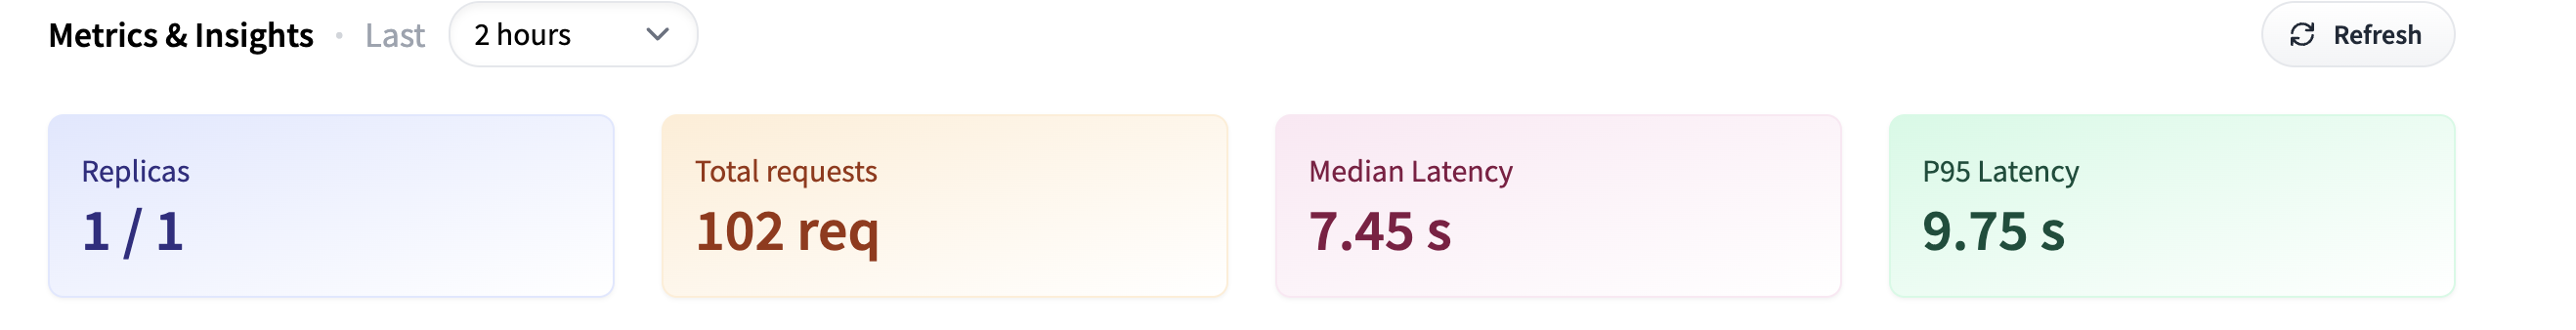